In [34]:
import pip

def import_or_install(package):
    try:
        __import__(package)
    except ImportError:
        pip.main(['install', package])       

import_or_install('tensorflow')
import_or_install('pydot')


In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [36]:
import pyarrow as pa
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from source import data_import

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

In [38]:
import tensorflow as tf

from tensorflow import keras as keras
from tensorflow.keras.models import Sequential # intitialize the ANN
from tensorflow.keras.layers import Dense, Activation, Dropout 

In [39]:
import source.plots as plots

In [40]:
RSEED = 42
np.random.seed(seed=RSEED)
tf.random.set_seed(RSEED)

feature_file_path = "data/features_240_dur05_all.npy"
model_file_path = "saved_model/my_RNN_model_60per5_fixing_overfit"

In [41]:
try:
    data
    print('data already loaded in parent notebook')
except NameError:
    data = np.load(feature_file_path, allow_pickle=True)
data.shape

data already loaded in parent notebook


(204680, 180, 63)

In [42]:
model = keras.models.load_model(model_file_path)

In [43]:
import numpy as np

def split_data(data, train_size=0.8, random_state=None):
    np.random.seed(seed=RSEED)

    # Assuming the first column contains the IDs
    ids_column = data[:, 0, 0]

    # Find unique epoch IDs
    unique_epoch_ids = np.unique(ids_column)

    # Shuffle the unique epoch IDs
    np.random.shuffle(unique_epoch_ids)

    # Calculate the number of unique epoch IDs for training, validation, and testing
    train_samples_nr = int(np.floor(train_size * len(unique_epoch_ids)))
    print(f'{train_samples_nr} of epochs for training, {len(unique_epoch_ids) - train_samples_nr} of epochs for testing/validation')

    # Split the unique epoch IDs into train, validation, and test sets

    train_sample_ids = unique_epoch_ids[:train_samples_nr]
    test_sample_ids = unique_epoch_ids[train_samples_nr:]

    # Create boolean masks for filtering
    train_mask = np.in1d(ids_column, train_sample_ids)
    test_mask = np.in1d(ids_column, test_sample_ids)

    # Apply the masks to create train, validation, and test samples
    train_sample = data[train_mask, :, :]
    test_sample = data[test_mask, :, :]

    X_train = train_sample[:,:,:-1]
    X_test = test_sample[:,:,:-1]

    Y_train = train_sample[:,:,-1]
    Y_test = test_sample[:,:,-1]

    y_test=Y_test.max(axis=1)
    y_train=Y_train.max(axis=1)

    return X_train, X_test, Y_train, Y_test, y_train, y_test


In [44]:
X_train, X_test, Y_train, Y_test, y_train, y_test = split_data(data)
print(f'train shape', X_train.shape, f'ratio of seizures {y_train.sum()/len(y_train):.2f}')
print(f'test shape {X_test.shape}, ratio of seizures {y_test.sum()/len(y_test):.2f}')

544 of epochs for training, 136 of epochs for testing/validation
train shape (163744, 180, 62) ratio of seizures 0.25
test shape (40936, 180, 62), ratio of seizures 0.22


In [45]:
# Scaling features
num_features_train = X_train[:,:,2:]
num_features_test = X_test[:,:,2:]

# Get the dimensions of the original array
num_epochs_tr, num_segments_per_epoch_tr, features_tr = num_features_train.shape
num_epochs_te, num_segments_per_epoch_te, features_te = num_features_test.shape

# Reshape the array to 2D
reshaped_array_train = num_features_train.reshape(num_epochs_tr * num_segments_per_epoch_tr, features_tr)
reshaped_array_test = num_features_test.reshape(num_epochs_te * num_segments_per_epoch_te, features_te)

# Scaling features
scaler = StandardScaler()
num_features_scaled_tr = scaler.fit_transform(reshaped_array_train)
num_features_scaled_te = scaler.transform(reshaped_array_test)

X_train_scaled = num_features_scaled_tr.reshape(num_epochs_tr, num_segments_per_epoch_tr, features_tr)
X_test_scaled = num_features_scaled_te.reshape(num_epochs_te, num_segments_per_epoch_te, features_te)

print(f'train shape', X_train_scaled.shape)
print(f'test shape', X_test_scaled.shape)

train shape (163744, 180, 60)
test shape (40936, 180, 60)


In [46]:
X_train = X_train_scaled
X_test = X_test_scaled

In [47]:
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

class_labels, class_counts = np.unique(y_train, return_counts=True)
total_samples = len(y_train)
class_weights = total_samples / (len(class_labels) * class_counts)

# Convert class weights to a dictionary
class_weight_dict = dict(zip(class_labels, class_weights))


In [48]:
class_weight_dict

{0.0: 0.6650366748166259, 1.0: 2.0148148148148146}

In [49]:
N_TRAIN = len(X_train)
EPOCHS = 30
BATCH_SIZE = 10000
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE

In [50]:
STEPS_PER_EPOCH

16

In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 lstm (LSTM)                 (None, 1024)              4444160   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 5498881 (20.98 MB)
Trainable params: 5496833 (20.97 MB)
Non-trainable params: 2048 (8.00 KB)
___________________________________

In [52]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Create EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Create ModelCheckpoint callback to save the best model
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Combine the callbacks in a list
callbacks = [early_stopping, model_checkpoint]

In [53]:
y_train.shape

(163744,)

In [54]:
history = model.history

AttributeError: 'NoneType' object has no attribute 'history'

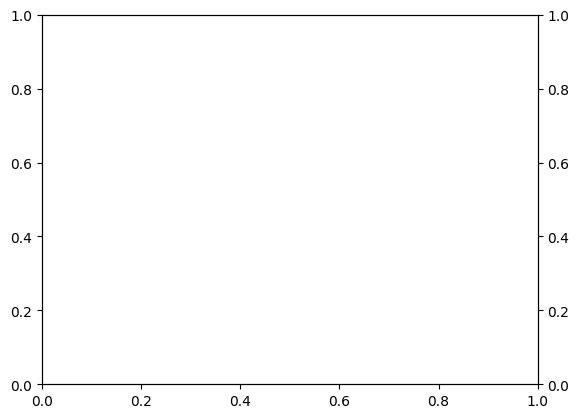

In [55]:
plots.plot_history_metrics(history)

In [58]:
metrics = model.evaluate(X_test, y_test, verbose=2)
print(f'Model accuracy: {metrics}')


1280/1280 - 104s - loss: 43.7614 - accuracy: 0.6736 - auc: 0.7107 - 104s/epoch - 81ms/step
Model accuracy: [43.76141357421875, 0.6736124753952026, 0.7107223868370056]


In [59]:
y_pred_train = model.predict(X_train)

5117/5117 [==============================] - 414s 81ms/step


In [60]:
y_pred = model.predict(X_test)
y_pred_c = y_pred.round().astype(int)
y_pred_c.shape

1280/1280 [==============================] - 107s 84ms/step


(40936, 1)

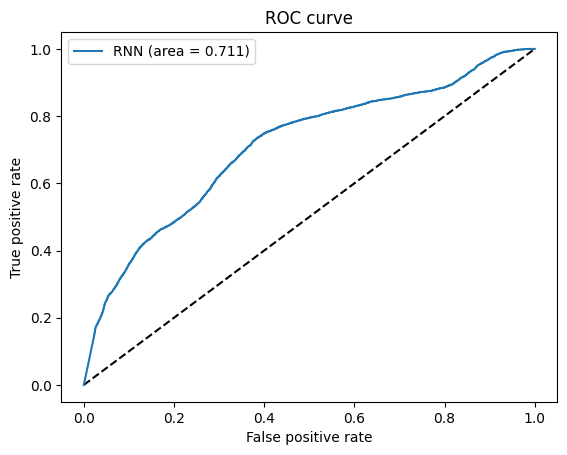

In [61]:
plots.plot_roc(y_test, y_pred)

In [62]:
metrics

[43.76141357421875, 0.6736124753952026, 0.7107223868370056]

In [63]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix
y_pred_c = y_pred.round().astype(int)
precision = precision_score(y_test, y_pred_c)
recall = recall_score(y_test, y_pred_c)

metrics = model.evaluate(X_test, y_test)

limit_index = lambda x, arr: min(x,len(arr))
print('Loss:', metrics[limit_index(0,metrics)])
print('AUC:', metrics[limit_index(1,metrics)])
print('Accuracy:', metrics[limit_index(2,metrics)])
print('Precision:', precision)
print('Recall:', recall)
y_test.sum(), y_pred_c.sum()


1280/1280 [==============================] - 107s 84ms/step - loss: 43.7614 - accuracy: 0.6736 - auc: 0.7107
Loss: 43.76141357421875
AUC: 0.6736124753952026
Accuracy: 0.7107223868370056
Precision: 0.3653044722274056
Recall: 0.6503875968992248


(9030.0, 16077)

In [64]:
# Print the results
print("Metrics: ", model.metrics_names)
print("Results: ", metrics)

Metrics:  ['loss', 'accuracy', 'auc']
Results:  [43.76141357421875, 0.6736124753952026, 0.7107223868370056]


In [67]:
model_checkpoint.best

inf

In [68]:
import capstone_plots

In [154]:
type(y_pred)

numpy.ndarray

In [102]:
X_test = np.load('data/X_test_wavelet.npy', allow_pickle=True)
y_test = np.load('data/y_test_wavelet.npy', allow_pickle=True)
y_pred_c = np.load('data/y_pred_c_wavelet.npy', allow_pickle=True)
y_pred = np.load('data/y_pred_wavelet.npy', allow_pickle=True)

d:\_c\spiced\ai-seizure-detectives\capstone_plots.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'ground_truth' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[1,'prediction'] = true_label
d:\_c\spiced\ai-seizure-detectives\capstone_plots.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'incoming seizure' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[1,'seizure'] = seizure_label
d:\_c\spiced\ai-seizure-detectives\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\_c\spiced\ai-seizure-detectives\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWar

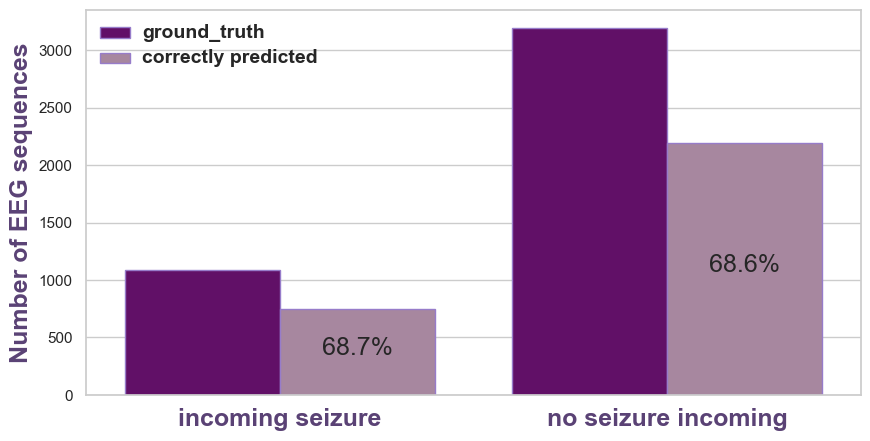

In [170]:
from importlib import reload
import capstone_plots

reload(capstone_plots)

capstone_plots.barplot(list(y_test), y_pred_c, 'prediction_barplot.png')

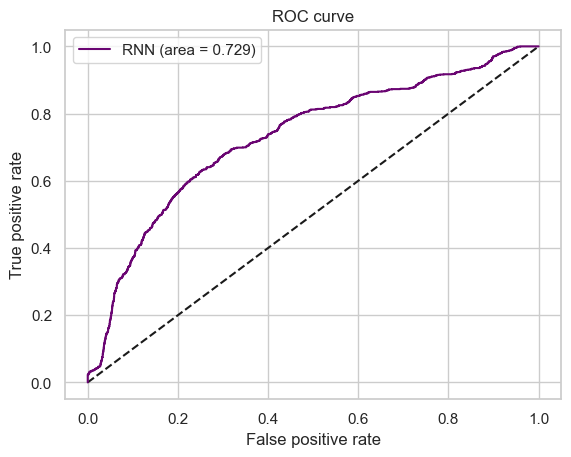

In [158]:
plots.plot_roc(y_test, y_pred)

d:\_c\spiced\ai-seizure-detectives\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\_c\spiced\ai-seizure-detectives\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\_c\spiced\ai-seizure-detectives\capstone_plots.py:146: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=fpr, y=tpr, label='RNN (area = {:.3f})'.format(auc_model), palette=custom_palette)
d:\_c\spiced\ai-seizure-detectives\venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating inste

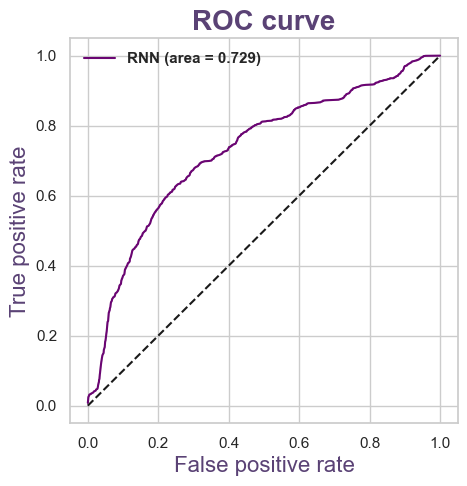

In [164]:
import capstone_plots 
reload(capstone_plots)

capstone_plots.plot_roc(y_test, y_pred, file_name='roc_wavelet.png')

In [126]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred_c)
print("Classification Report:")
print(report)
precision = precision_score(y_test, y_pred_c)
print(f"precision: {precision:.2f}")
 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.69      0.77      3193
         1.0       0.43      0.69      0.53      1085

    accuracy                           0.69      4278
   macro avg       0.65      0.69      0.65      4278
weighted avg       0.75      0.69      0.70      4278

precision: 0.43


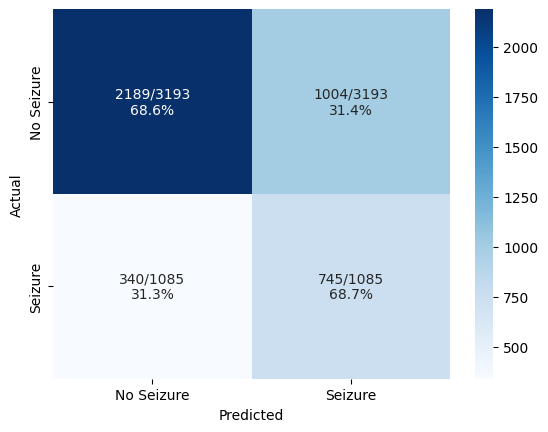

In [107]:
plots.plot_confusion_matrix(y_test, y_pred_c)

In [167]:
2189/(2189+1004)


0.6855621672408393

In [131]:
1004 / (len(y_test) * 30 * 2 / 3600 / 24)

337.9523141654979